In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from transformer_onestep_CL import GPTClosedLoop
import tqdm
import argparse

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [3]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [5]:
import torch
import subprocess
import re

def get_gpu_memory_map():
    """Get the current GPU usage using nvidia-smi.

    Returns
    -------
    memory_map: dict
        Keys are device ids as integers.
        Values are memory free on that device in MB as integers.
    """
    # Run nvidia-smi command to get memory information
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free,memory.total', '--format=csv,nounits,noheader'], encoding='utf-8'
    )

    # Extract the memory information
    gpu_memory = [tuple(map(int, x.split(','))) for x in result.strip().split('\n')]

    # Create a memory map as a dictionary
    memory_map = {i: free for i, (free, total) in enumerate(gpu_memory)}
    return memory_map

def select_gpu_with_most_free_memory():
    """Select the GPU with the most available memory."""
    if torch.cuda.is_available():
        memory_map = get_gpu_memory_map()
        best_gpu = max(memory_map, key=memory_map.get)
        torch.cuda.set_device(best_gpu)
        print(f"Selected GPU {best_gpu} with {memory_map[best_gpu]} MB free memory.")
        return best_gpu
    else:
        print("No GPU available, using CPU.")
        return None

In [6]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
# Example usage
best_gpu = select_gpu_with_most_free_memory()
cuda_device = 'cuda:3'#f'cuda:{best_gpu}' if best_gpu is not None else 'cpu'
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.cuda.set_device(device)
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

Selected GPU 0 with 23955 MB free memory.


In [7]:
torch.cuda.is_available()

True

In [8]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_evaporation_v11.pt", map_location=device)

In [9]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [10]:
# del exp_data["model_args"]['use_pi']

In [11]:
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model_CL = GPTClosedLoop(gptconf).to(device)

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_CL.load_state_dict(state_dict)
model = model_CL.gpt_model

number of parameters: 0.10M


In [12]:
exp_data.keys()

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

In [13]:
exp_data['iter_num']

26405

In [14]:
np.sqrt(exp_data['best_val_loss'])

0.020328781217900705

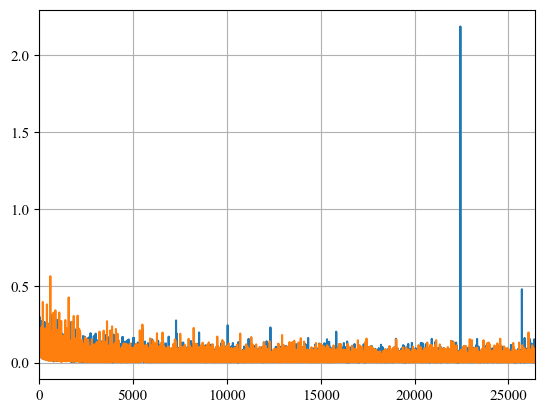

In [15]:
plt.plot(exp_data['LOSS'])
plt.plot(exp_data['LOSS_VAL'])
# plt.ylim([0, 0.05])

In [16]:
exp_data['train_time'] / 3600

99.1826839675506

In [17]:
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, drss_matrices
set_seed(42)

seq_len = 300   
nx = 2
nu = 1
ny = 1
 
# define settings
ts = 1  

# define nominal model
G = drss_matrices(nx, nu, ny, device=device)

In [18]:
from signals_torch import steps_sequence
from dataset_CL_evaporation_process import EvaporationDataset

seq_len = 100
ts = 1

dataset = EvaporationDataset(seq_len=seq_len, ts=ts, seed=42, data_perturb_percentage=5)
dataloader = DataLoader(dataset, batch_size=batch_size)
# data, batch_r, batch_y_d = next(iter(dataloader))
# data, batch_r, batch_y_d = next(iter(dataloader))

# T = 100
# t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)
# r = torch.zeros((T,2), device=device, dtype=torch.float32)
# 
# r[:,0] = steps_sequence(T, ts, 20, 25, 20, 50).T
# r[:,1] = steps_sequence(T, ts, 40, 60, 20, 50).T
# r = batch_r[0,:,:]
# y_d = batch_y_d[0,:,:]
# t = torch.arange(0, seq_len, ts, device=device, dtype=torch.float32).view(-1, 1)

# plt.plot(t.cpu().numpy(), r.cpu().numpy())
# plt.plot(t.cpu().numpy(), y_d.cpu().numpy())

In [19]:
print(model.proportional_coefficient)
print(model.integral_coefficient)
print(model.derivative_coefficient)

Parameter containing:
tensor([2.2676], device='cuda:3', requires_grad=True)
Parameter containing:
tensor([1.9849], device='cuda:3', requires_grad=True)
Parameter containing:
tensor([0.5618], device='cuda:3', requires_grad=True)


In [21]:
from evaporation_process import problem_data, dynamics
import pickle
H = 100

n_test = 20

T = 100
t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)

E_log = np.zeros((n_test, len(t), 2))
U_log = np.zeros((n_test, len(t), 2))
Y_log = np.zeros((n_test, len(t), 2))
R_log = np.zeros((n_test, len(t), 2))
Y_d_log = np.zeros((n_test, len(t), 2))

with open('evaporation_process_test_set_5%2525.pickle', 'rb') as handle:
    test_set = pickle.load(handle)
with open('evaporation_process_r.pickle', 'rb') as handle:
    batch_r = pickle.load(handle)
with open('evaporation_process_y_d.pickle', 'rb') as handle:
    batch_y_d = pickle.load(handle)

T = np.zeros((n_test, len(t)))
for key in range(n_test):
    
    print(key)
    
    # _, batch_r, batch_y_d = next(iter(dataloader))
    data = test_set[key]
    
    r = batch_r[0,:,:]
    y_d = batch_y_d[0,:,:]
    
    E = torch.empty((n_test, len(t), 2), device=device, dtype=torch.float32)
    U = torch.empty((n_test, len(t)+1, 2), device=device, dtype=torch.float32)
    Y = torch.empty((n_test, len(t), 2), device=device, dtype=torch.float32)
    
    with torch.no_grad():
        # initial
        U[key, 0, :] = torch.tensor([191.713, 215.888], device=device, dtype=torch.float32).unsqueeze(0).repeat(1, 1)
        y_i = batch_y_d[key:key+1,0,:]
        x_i = y_i.clone()
        
        for i in range(len(t)):
            
            print(y_i)
            # print('time instant:', i)
            # start the loop with error
            e_i = r[i] - y_i

            Y[key,i,:] = y_i
            E[key,i,:] = e_i
            
            # Controller u(t) = C(e(t),u(t-1))
            start = time.time()
            if i < H:
                pred = model(E[:, :i+1, :], U[:, :i+1, :])
            else:
                pred = model(E[:, i-H+1:i+1, :], U[:, i-H+1:i+1, :])
            T[key,i] = time.time() - start
            
            U[:, i+1, :] = pred[:,-1,:]  # Just for coherence

            # Simulate system response
            x_dot = dynamics(x_i[0], U[key, i+1, :], *data)
            # Integrate dynamics using forward Euler integration
            x_i = x_i + ts * x_dot + torch.randn_like(x_dot) * 0.1
            y_i = x_i.clone() + torch.randn_like(x_dot) * 0.1
            
            
    E_log[key] = E[key,:,:].cpu().numpy()
    U_log[key] = U[key,1:,:].cpu().numpy()
    Y_log[key] = Y[key,:,:].cpu().numpy()
    R_log[key] = batch_r[key,:,:].cpu().numpy()
    Y_d_log[key] = batch_y_d[key,:,:].cpu().numpy()
    
    if key == n_test-1:
        break

0
tensor([[21.1502, 40.4471]], device='cuda:3')
tensor([[22.3926, 41.5240]], device='cuda:3')
tensor([[23.3846, 42.7394]], device='cuda:3')
tensor([[23.6771, 43.5427]], device='cuda:3')
tensor([[23.5150, 44.1179]], device='cuda:3')
tensor([[24.2369, 44.5891]], device='cuda:3')
tensor([[23.4618, 44.9890]], device='cuda:3')
tensor([[24.1910, 45.4534]], device='cuda:3')
tensor([[23.8092, 46.1345]], device='cuda:3')
tensor([[23.8298, 46.3523]], device='cuda:3')
tensor([[23.9584, 46.7191]], device='cuda:3')
tensor([[23.6835, 47.0679]], device='cuda:3')
tensor([[24.2931, 47.3963]], device='cuda:3')
tensor([[23.9772, 47.8008]], device='cuda:3')
tensor([[23.7283, 48.2673]], device='cuda:3')
tensor([[24.2350, 49.0230]], device='cuda:3')
tensor([[23.9059, 49.1354]], device='cuda:3')
tensor([[24.0031, 49.7622]], device='cuda:3')
tensor([[23.8285, 50.2473]], device='cuda:3')
tensor([[24.0034, 50.4560]], device='cuda:3')
tensor([[23.7235, 50.9907]], device='cuda:3')
tensor([[24.0578, 51.4018]], dev

In [22]:
context_results = {'U':U_log, 'Y':Y_log, 'R':R_log, 'Y_d':Y_d_log, 'E_log':E_log}

# with open('context_results_trivial', 'wb') as handle:
#     pickle.dump(context_results, handle)

In [30]:
T.std()

0.00017279153165182393

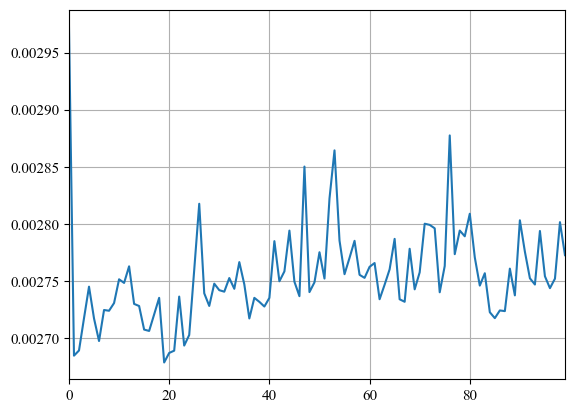

In [28]:
plt.plot(T.mean(axis=0))

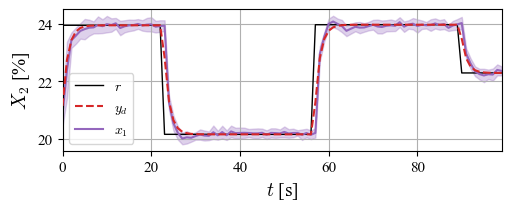

In [23]:
# Create a 2x1 subplot layout for the main figure
fig = plt.figure(figsize=(5, 2), constrained_layout=True)

mean_Y = Y_log[:,:,0].mean(axis=0)
std_Y = Y_log[:,:,0].std(axis=0)

plt.plot(t.cpu().numpy(), R_log[0,:,0].T, label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), Y_d_log[0,:,0].T, label="$y_d$", c='tab:red', linestyle='--', zorder=3)
plt.plot(mean_Y, color='tab:purple', label='$x_1$')
plt.fill_between(range(len(mean_Y)), mean_Y - std_Y, mean_Y + std_Y, color='tab:purple', alpha=0.3)
# plt.plot(Y_log[:,:,0].T, color='tab:purple', alpha=0.2)

plt.legend()

plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$ [%]')

# plt.savefig('meta_performance.pdf')

plt.show()

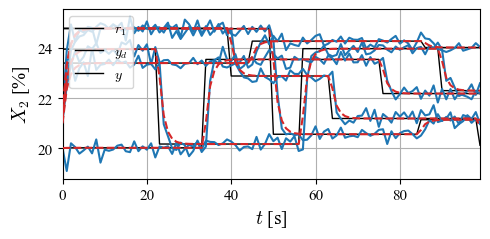

In [68]:
plt.figure(figsize=(5, 2.5))
plt.plot(t.cpu().numpy(), R_log[:5,:,0].T, label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), Y_d_log[:5,:,0].T, label="$y_d$", c='tab:red', linestyle='--', zorder=3)
plt.plot(t.cpu().numpy(), Y_log[:5,:,0].T, c='tab:blue', alpha=1, label="no_label")
plt.legend(['$r_1$','$y_d$','$y$'], loc='upper left')
# plt.xlim([0, 0.43])
# plt.ylim([19, 26])
# plt.tick_params('x', labelbottom=False)
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$ [%]')
plt.tight_layout()
# plt.savefig("evaporation_evaporation_meta.pdf")
plt.show()

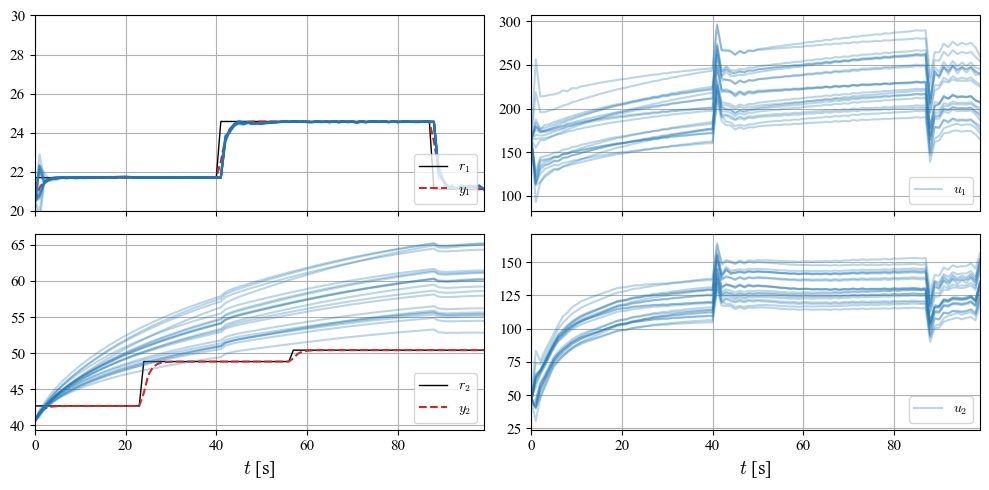

In [28]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(221)
#plt.plot(t_CL, r)
plt.plot(t.cpu().numpy(), r[:,0].cpu().numpy(), label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), y_d[:,0].cpu().numpy(), label="$y_d$", c='tab:red', linestyle='--')
plt.plot(t.cpu().numpy(), Y_log[:,:,0].T, c='tab:blue', alpha=.3)
plt.legend(['$r_1$','$y_1$'], loc='lower right')
# plt.xlim([0, 0.43])
plt.ylim([20, 30])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(t.cpu().numpy(), r[:,1].cpu().numpy(), label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), y_d[:,1].cpu().numpy(), label="$y_d$", c='tab:red', linestyle='--')
plt.plot(t.cpu().numpy(), Y_log[:,:,1].T, c='tab:blue', alpha=.3)
plt.legend(['$r_2$','$y_2$'], loc='lower right')
plt.xlabel('$t$ [s]')
# plt.xlim([10, 12])


ax3 = plt.subplot(222, sharex=ax1)
plt.plot(t.cpu().numpy(), U_log[:,:,0].T, c='tab:blue', alpha=.3)
# plt.ylim([0, 4])
plt.legend(['$u_1$'], loc='lower right')
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(224, sharex=ax1)
plt.plot(t.cpu().numpy(), U_log[:,:,1].T, c='tab:blue', alpha=.3)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$u_2$'], loc='lower right')

# plt.savefig('transformer_controller.pdf')
# Improve the layout to avoid overlapping
plt.tight_layout()

plt.show()